In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(content="So you were researching on ocean mammals?", name="Model")]
messages.append(HumanMessage(content="Yes, I was researching on ocean mammals", name="User"))
messages.append(AIMessage(content="I see, how can I help you?", name="Model"))
messages.append(HumanMessage(content="Can whales understand human language?", name="User"))

for message in messages:
    print(message.name, ":", message.content)

Model : So you were researching on ocean mammals?
User : Yes, I was researching on ocean mammals
Model : I see, how can I help you?
User : Can whales understand human language?


## Adding a chat model

In [6]:
import os, getpass
from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
chat_model = ChatOpenAI(model="gpt-4o-mini")

result = chat_model.invoke(messages)
type(result)
result

AIMessage(content='Whales do not understand human language in the way that humans do. While some species of whales, such as dolphins—which are also cetaceans—can learn to respond to certain commands and cues from trainers, this is not the same as understanding human language. \n\nWhales communicate using a complex system of sounds and vocalizations that they use to socialize, navigate, and hunt. Research has shown that some whale species can recognize distinct calls and adjust their behavior based on these sounds, suggesting a form of social communication that is advanced in its own right. However, they do not comprehend language in the human sense, which involves grammar, syntax, and abstract concepts.\n\nOngoing research continues to explore the cognitive abilities of whales and other cetaceans, so our understanding of their communication and intelligence may evolve over time.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 162, 'prompt_

As you can see, `invoke` returns the AI response message only, not the full list of messages. 

## Adding a tool

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply two integers and return the result."""
    return a * b
chat_model_with_tools = chat_model.bind_tools([multiply])

In [8]:
tool_call = chat_model_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3")])

In [9]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EYtUr6twEN9xbO2OJkrorFE7', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 56, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C6JzcMJH5jN2cqNMUZqn3Jfiemdso', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bf3b824f-b083-4355-890e-f376d64e2da9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_EYtUr6twEN9xbO2OJkrorFE7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 17, 'total_tokens': 73, 'input_token_details': {'audio': 0, 'cach

In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesList(TypedDict):
    messages: list[AnyMessage]

## Adding a Reducer - Example

In [13]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
class State(TypedDict):
    num: int
    arr: list[str]

def node_1(state: State) -> State:
    return {"num": 2}
def node_2(state: State) -> State:
    return {"arr": ["bye"]}

graph = StateGraph(State)
graph.add_node("node_1", node_1)
graph.add_node("node_2", node_2)
graph.add_edge(START, "node_1")
graph.add_edge("node_1", "node_2")
graph.add_edge("node_2", END)

compiled_graph = graph.compile()
compiled_graph.invoke({"num": 1, "arr": ["hi"]})




{'num': 2, 'arr': ['bye']}

In [14]:
from typing_extensions import TypedDict
from typing import Annotated
from operator import add
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
class State(TypedDict):
    num: int
    arr: Annotated[list[str], add] ## Annotated[type, reducer]

def node_1(state: State) -> State:
    return {"num": 2}
def node_2(state: State) -> State:
    return {"arr": ["bye"]}

graph = StateGraph(State)
graph.add_node("node_1", node_1)
graph.add_node("node_2", node_2)
graph.add_edge(START, "node_1")
graph.add_edge("node_1", "node_2")
graph.add_edge("node_2", END)

compiled_graph = graph.compile()
compiled_graph.invoke({"num": 1, "arr": ["hi"]})

{'num': 2, 'arr': ['hi', 'bye']}

## Perplexity says: 
Here's the breakdown:

The use of Annotated[list[str], add] for the arr field attaches the add reducer to that field as type metadata.

When you create the StateGraph with your custom State TypedDict, LangGraph inspects these annotations.

LangGraph internally checks: if a field is annotated with Annotated[..., reducer], it uses that reducer function (here, add) to combine the field’s new state with its previous value.

For lists and operator.add, this means concatenation (appending).

If no reducer is specified, updates default to overwriting the previous value instead.

You do not implement this logic yourself.
LangGraph's StateGraph reads that Annotated type hint at graph construction time (via Python type introspection), and wires up the reducer logic accordingly for state updates.
> TL;DR: The presence of add in the annotation tells LangGraph specifically for the arr key to combine values using operator.add (list concatenation). LangGraph's internal code is what makes this happen—Annotated is just how you tell it what to do.

## Create the state graph with the llm

In [15]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

## What does this mean? 
Having a messages state is very common. So, LangGraph has a default template for the state graphs which has a `messages` state, along with an `addmessages` reducer. So, if a node returns a `message`, it is appended to the `messages` state, not replaced, automatically. No add. code needed.

### `pass` keyword
**Perplexity:** The pass keyword at the end of a class in Python is used as a placeholder that does nothing. Python requires the body of a class (or functions, loops, etc.) to have at least one statement, and pass fulfills this requirement without adding any behavior or logic.

For example:

```python
class MyEmptyClass:
    pass
```
This defines an empty class; no attributes or methods are on it yet.

The pass statement ensures your code is syntactically valid and does not raise an error for a blank class body.

You usually use pass when you're outlining your code structure and plan to add details later, or you want a placeholder for a class or function that is required syntactically but should do nothing for now.

Related
How does the pass keyword function specifically at the end of a class declaration
Why is pass used in class definitions instead of leaving the body empty
Can pass at the end of a class help with code scaffolding or future expansion
How does the pass statement compare to other placeholders in class construction
What is the effect of using pass in a class versus leaving it completely empty


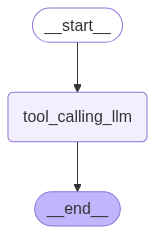

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# LLM Node
def tool_calling_llm(state: MessagesState): 
    return {"messages": chat_model_with_tools.invoke(state["messages"])}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

# Compile the graph
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
resultant_state = graph.invoke({"messages": HumanMessage(content = "I want to talk to whales")})

for message in resultant_state["messages"]:
    message.pretty_print()

================================ Human Message =================================

I want to talk to whales
================================== Ai Message ==================================

Talking to whales is a fascinating idea! While we can't communicate with them in a way that humans do with each other, researchers have studied whale songs and sounds. If you're interested, we can explore topics like whale communication, species of whales, or how to listen to them in the wild. What would you like to know more about?


In [20]:
resultant_state["messages"]

[HumanMessage(content='I want to talk to whales', additional_kwargs={}, response_metadata={}, id='5304343f-1c48-4864-86c5-a1d18b475af3'),
 AIMessage(content="Talking to whales is a fascinating idea! While we can't communicate with them in a way that humans do with each other, researchers have studied whale songs and sounds. If you're interested, we can explore topics like whale communication, species of whales, or how to listen to them in the wild. What would you like to know more about?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 54, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C6Kh6UdQ8avmRnVdtORl8sYqpUkts', 'service_tier': 'default', 'finis

In [22]:
multiply_result = graph.invoke({"messages": HumanMessage(content = "What is 2 * 3?")})

In [23]:
multiply_result

{'messages': [HumanMessage(content='What is 2 * 3?', additional_kwargs={}, response_metadata={}, id='32a5795d-fac5-4fad-9fda-e168830909ad'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cbOPlnlKNOx2g8WVio2e9mgk', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 56, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C6Kkjx4mgGPpM3V8akHJEw4azA8wW', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f2ad20fc-de11-409c-97f8-597d9cef0832-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_cbOPlnlKNOx2g8WVio2e9mgk'

In [24]:
for msg in multiply_result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 2 * 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_cbOPlnlKNOx2g8WVio2e9mgk)
 Call ID: call_cbOPlnlKNOx2g8WVio2e9mgk
  Args:
    a: 2
    b: 3
